In [2]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
# -------------------------------
# Step 1: Load and Clean WHQ_df (with BMI Calculation)
# -------------------------------
WHQ_df = pd.read_csv('WHQ_L.csv')

# Replace the placeholder values (7777, 9999, and blanks) with NaN
WHQ_df.replace({7777: np.nan, 9999: np.nan}, inplace=True)
WHQ_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
WHQ_df.dropna(inplace=True)

# Calculate BMI using the formula: BMI = (weight in lbs / (height in inches)^2) * 703
WHQ_df['BMI'] = (WHQ_df['WHD020'] / (WHQ_df['WHD010'] ** 2)) * 703

# Define a function to classify BMI
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Healthy Weight'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Class 1 Obesity'
    elif bmi < 40:
        return 'Class 2 Obesity'
    else:
        return 'Class 3 Obesity'

# Apply the classification to create a new column
WHQ_df['BMI_category'] = WHQ_df['BMI'].apply(classify_bmi)

WHQ_df.drop(['WHD010', 'WHD020', 'WHD050' ,'WHQ070', 'BMI' ], axis=1, inplace=True)

print("First few rows of cleaned WHQ_df:")
print(WHQ_df.head())

First few rows of cleaned WHQ_df:
       SEQN     BMI_category
0  130378.0       Overweight
1  130379.0  Class 1 Obesity
2  130380.0       Overweight
3  130384.0  Class 1 Obesity
4  130385.0  Class 1 Obesity


In [4]:
# -------------------------------
# Step 2: Load the Other DataFrames
# -------------------------------
ALQ_df    = pd.read_csv('ALQ_L.csv')
BAX_df    = pd.read_csv('BAX_L.csv')
#BMX_df    = pd.read_csv('BMX_L.csv')
BPQ_df    = pd.read_csv('BPQ_L.csv')
BPXO_df   = pd.read_csv('BPXO_L.csv')
DBQ_df    = pd.read_csv('DBQ_L.csv')
DEMO_df   = pd.read_csv('DEMO_L.csv')
DR1IFF_df = pd.read_csv('DR1IFF_L.csv')
MCQ_df    = pd.read_csv('MCQ_L.csv')
PAQ_df    = pd.read_csv('PAQ_L.csv')
# Note: WHQ_df is already loaded and processed above.

In [5]:
# -------------------------------
# Step 3: Merge All DataFrames on 'SEQN'
# -------------------------------
dfs = [ALQ_df, BAX_df, BPQ_df, BPXO_df, DBQ_df, DEMO_df, DR1IFF_df, MCQ_df, PAQ_df, WHQ_df]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='outer'), dfs)

print("Columns in merged_df:")
print(merged_df.columns)

Columns in merged_df:
Index(['SEQN', 'ALQ111', 'ALQ121', 'ALQ130', 'ALQ142', 'ALQ270', 'ALQ280',
       'ALQ151', 'ALQ170', 'BAXMSTAT',
       ...
       'MCQ230D', 'OSQ230', 'PAD790Q', 'PAD790U', 'PAD800', 'PAD810Q',
       'PAD810U', 'PAD820', 'PAD680', 'BMI_category'],
      dtype='object', length=246)


In [6]:
# -------------------------------
# Step 4: Clean Merged Data
# -------------------------------
# Drop rows missing the target 'BMI_category'
merged_df.dropna(subset=['BMI_category'], inplace=True)

# Fill missing values with 0 for all remaining columns
merged_df.fillna(0, inplace=True)



In [7]:
merged_df['BMI_category'].head()

0    Overweight
1    Overweight
2    Overweight
3    Overweight
4    Overweight
Name: BMI_category, dtype: object

In [8]:
# -------------------------------
# Step 5: Prepare Features and Target
# -------------------------------
y = merged_df['BMI_category']
X = merged_df.drop(['BMI_category', 'SEQN'], axis=1)

# One-hot encode categorical variables in X
X = pd.get_dummies(X)

In [9]:
# -------------------------------
# Step 6: Stratified Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# -------------------------------
# Step 7: Scaling Features
# -------------------------------
scaler = StandardScaler()

# Scale the training data and transform test data, preserving column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [11]:
# -------------------------------
# Step 8: Apply SMOTE to Balance the Training Data
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("Training set distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

print("\nTest set distribution (original composition):")
print(y_test.value_counts())

Training set distribution after SMOTE:
BMI_category
Overweight         21512
Class 1 Obesity    21512
Class 2 Obesity    21512
Healthy Weight     21512
Class 3 Obesity    21512
Underweight        21512
Name: count, dtype: int64

Test set distribution (original composition):
BMI_category
Overweight         5379
Healthy Weight     5042
Class 1 Obesity    2941
Class 2 Obesity    1297
Class 3 Obesity     996
Underweight         280
Name: count, dtype: int64


In [12]:
# -------------------------------
# Step 9: Baseline Random Forest Model (using resampled training data)
# -------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [13]:
# -------------------------------
# Step 10: Permutation Feature Importance on Test Set
# -------------------------------
perm_importance = permutation_importance(
    rf, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='f1_macro'
)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_10_features = X_train_scaled.columns[sorted_idx][:14]
print("Top 10 Features:")
print(top_10_features)

Top 10 Features:
Index(['BPAOCSZ', 'RIDAGEYR', 'PAD680', 'PAD820', 'BPQ101D', 'BPQ080',
       'BPQ020', 'BPQ030', 'MCQ195', 'DBQ424', 'DBQ330', 'PAD790U_b'D'',
       'RIAGENDR', 'DMDHHSIZ'],
      dtype='object')


In [14]:
# -------------------------------
# Step 11: Retrain Random Forest Using Top 10 Features
# -------------------------------
X_train_top10 = X_train_scaled[top_10_features]
X_test_top10  = X_test_scaled[top_10_features]

# Apply SMOTE on the top-10 training features as well
X_train_top10_res, y_train_top10_res = smote.fit_resample(X_train_top10, y_train)

rf_top10 = RandomForestClassifier(random_state=42)
rf_top10.fit(X_train_top10_res, y_train_top10_res)

y_pred_top10 = rf_top10.predict(X_test_top10)
print("\nClassification Report using Top 10 Features:")
print(classification_report(y_test, y_pred_top10))


Classification Report using Top 10 Features:
                 precision    recall  f1-score   support

Class 1 Obesity       0.97      0.96      0.97      2941
Class 2 Obesity       0.95      0.96      0.96      1297
Class 3 Obesity       0.96      0.97      0.96       996
 Healthy Weight       0.97      0.96      0.97      5042
     Overweight       0.97      0.96      0.97      5379
    Underweight       0.75      0.94      0.84       280

       accuracy                           0.96     15935
      macro avg       0.93      0.96      0.94     15935
   weighted avg       0.96      0.96      0.96     15935



In [15]:
from sklearn.metrics import classification_report

# Predict on the training set (using the SMOTE-resampled training data)
y_pred_train = rf.predict(X_train_res)

# Predict on the test set (using the scaled test data)
y_pred_test = rf.predict(X_test_scaled)

print("Training Performance:")
print(classification_report(y_train_res, y_pred_train))

print("Test Performance:")
print(classification_report(y_test, y_pred_test))


Training Performance:
                 precision    recall  f1-score   support

Class 1 Obesity       1.00      1.00      1.00     21512
Class 2 Obesity       1.00      1.00      1.00     21512
Class 3 Obesity       1.00      1.00      1.00     21512
 Healthy Weight       1.00      1.00      1.00     21512
     Overweight       1.00      1.00      1.00     21512
    Underweight       1.00      1.00      1.00     21512

       accuracy                           1.00    129072
      macro avg       1.00      1.00      1.00    129072
   weighted avg       1.00      1.00      1.00    129072

Test Performance:
                 precision    recall  f1-score   support

Class 1 Obesity       0.98      0.97      0.98      2941
Class 2 Obesity       0.98      0.97      0.98      1297
Class 3 Obesity       0.98      0.96      0.97       996
 Healthy Weight       0.97      0.99      0.98      5042
     Overweight       0.98      0.98      0.98      5379
    Underweight       0.97      0.94      0.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define a grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Fit the model on the resampled training data
grid_search.fit(X_train_res, y_train_res)

# Print the best hyperparameters and the best cross-validation score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best estimator to predict on the scaled test data
best_rf = grid_search.best_estimator_
y_pred_test_best = best_rf.predict(X_test_scaled)

# Evaluate performance on the test set
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_test_best))


Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.9895

Classification Report for Tuned Model:
                 precision    recall  f1-score   support

Class 1 Obesity       0.98      0.97      0.98      2941
Class 2 Obesity       0.98      0.96      0.97      1297
Class 3 Obesity       0.98      0.96      0.97       996
 Healthy Weight       0.97      0.98      0.98      5042
     Overweight       0.98      0.98      0.98      5379
    Underweight       0.96      0.94      0.95       280

       accuracy                           0.98     15935
      macro avg       0.98      0.97      0.97     15935
   weighted avg       0.98      0.98      0.98     15935



Training Performance:
                 precision    recall  f1-score   support

Class 1 Obesity       1.00      1.00      1.00     21512
Class 2 Obesity       1.00      1.00      1.00     21512
Class 3 Obesity       1.00      1.00      1.00     21512
 Healthy Weight       1.00      1.00      1.00     21512
     Overweight       1.00      1.00      1.00     21512
    Underweight       1.00      1.00      1.00     21512

       accuracy                           1.00    129072
      macro avg       1.00      1.00      1.00    129072
   weighted avg       1.00      1.00      1.00    129072

Test Performance:
                 precision    recall  f1-score   support

Class 1 Obesity       0.98      0.97      0.98      2941
Class 2 Obesity       0.98      0.96      0.97      1297
Class 3 Obesity       0.98      0.96      0.97       996
 Healthy Weight       0.97      0.98      0.98      5042
     Overweight       0.98      0.98      0.98      5379
    Underweight       0.96      0.94      0.

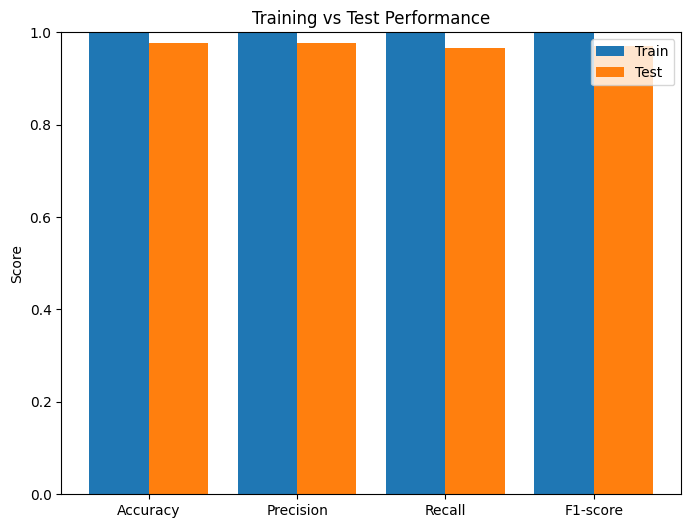

In [17]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Use the tuned model instance (ensure best_rf is fitted)
y_pred_train = best_rf.predict(X_train_res)
y_pred_test = best_rf.predict(X_test_scaled)

print("Training Performance:")
print(classification_report(y_train_res, y_pred_train))

print("Test Performance:")
print(classification_report(y_test, y_pred_test))

# Extract metrics for plotting
# Using output_dict=True to get a dictionary of metrics
train_report = classification_report(y_train_res, y_pred_train, output_dict=True)
test_report  = classification_report(y_test, y_pred_test, output_dict=True)

# Define metrics to plot: overall accuracy and macro averages of precision, recall, f1-score
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

train_scores = [
    train_report['accuracy'],
    train_report['macro avg']['precision'],
    train_report['macro avg']['recall'],
    train_report['macro avg']['f1-score']
]

test_scores = [
    test_report['accuracy'],
    test_report['macro avg']['precision'],
    test_report['macro avg']['recall'],
    test_report['macro avg']['f1-score']
]

# Create a grouped bar chart for comparison
x = range(len(metrics_labels))
plt.figure(figsize=(8, 6))
plt.bar([p - 0.2 for p in x], train_scores, width=0.4, label='Train')
plt.bar([p + 0.2 for p in x], test_scores, width=0.4, label='Test')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Training vs Test Performance')
plt.legend()
plt.show()


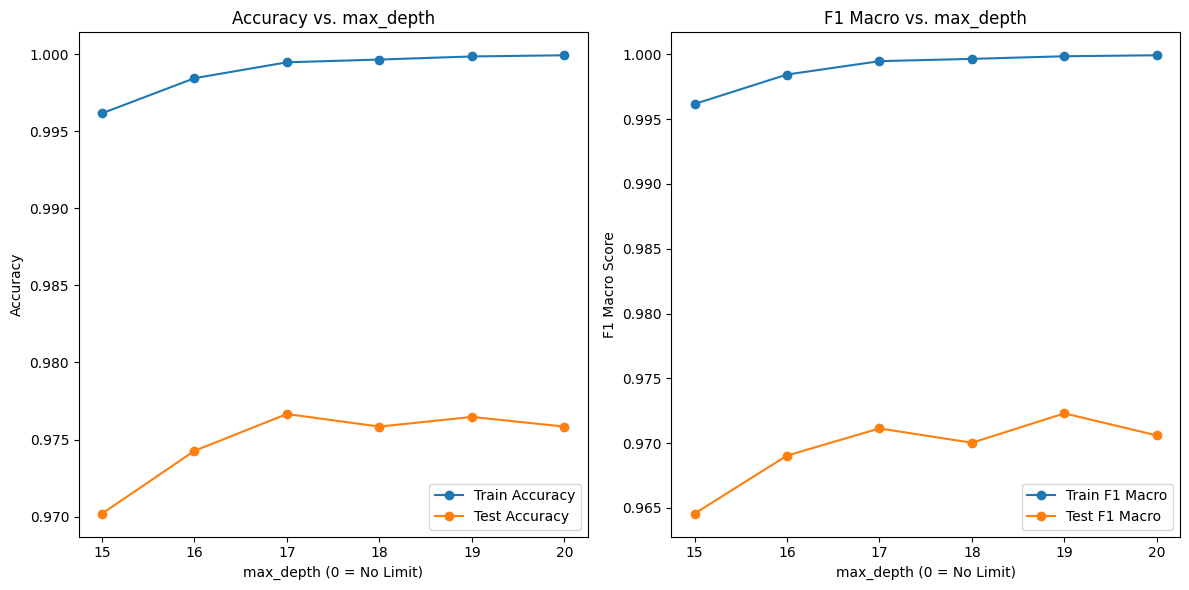

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# List of max_depth values to try (None means no limit, which is the default and usually leads to overfitting)
max_depth_values = [15,16,17,18,19,20]

train_accuracies = []
test_accuracies = []
train_f1s = []
test_f1s = []

# Loop over the different max_depth values
for md in max_depth_values:
    # Initialize a new RandomForestClassifier with the given max_depth
    rf_temp = RandomForestClassifier(random_state=42, max_depth=md, n_jobs=-1)
    # Fit on the SMOTE-resampled training data
    rf_temp.fit(X_train_res, y_train_res)
    
    # Predict on the training set and on the scaled test set
    y_pred_train_temp = rf_temp.predict(X_train_res)
    y_pred_test_temp = rf_temp.predict(X_test_scaled)
    
    # Record the accuracy and f1_macro scores
    train_accuracies.append(accuracy_score(y_train_res, y_pred_train_temp))
    test_accuracies.append(accuracy_score(y_test, y_pred_test_temp))
    train_f1s.append(f1_score(y_train_res, y_pred_train_temp, average='macro'))
    test_f1s.append(f1_score(y_test, y_pred_test_temp, average='macro'))

# Plotting the performance metrics
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
# For the x-axis, replace "None" with a label for plotting purposes (e.g., 0 or "No Limit")
x_vals = [0 if md is None else md for md in max_depth_values]
plt.plot(x_vals, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(x_vals, test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('max_depth (0 = No Limit)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. max_depth')
plt.legend()

# F1 Macro Score plot
plt.subplot(1, 2, 2)
plt.plot(x_vals, train_f1s, marker='o', label='Train F1 Macro')
plt.plot(x_vals, test_f1s, marker='o', label='Test F1 Macro')
plt.xlabel('max_depth (0 = No Limit)')
plt.ylabel('F1 Macro Score')
plt.title('F1 Macro vs. max_depth')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the RandomForestClassifier with max_depth=17
rf_best = RandomForestClassifier(max_depth=10, random_state=42, n_jobs=-1)

# Fit the model on the SMOTE-resampled training data
rf_best.fit(X_train_res, y_train_res)

# Predict on the training and test sets
y_pred_train_best = rf_best.predict(X_train_res)
y_pred_test_best  = rf_best.predict(X_test_scaled)

# Print the classification reports
print("Training Performance with max_depth=17:")
print(classification_report(y_train_res, y_pred_train_best))

print("Test Performance with max_depth=17:")
print(classification_report(y_test, y_pred_test_best))


Training Performance with max_depth=17:
                 precision    recall  f1-score   support

Class 1 Obesity       0.82      0.90      0.86     21512
Class 2 Obesity       0.92      0.95      0.94     21512
Class 3 Obesity       0.95      0.97      0.96     21512
 Healthy Weight       0.79      0.90      0.84     21512
     Overweight       0.90      0.61      0.73     21512
    Underweight       0.96      0.99      0.98     21512

       accuracy                           0.89    129072
      macro avg       0.89      0.89      0.88    129072
   weighted avg       0.89      0.89      0.88    129072

Test Performance with max_depth=17:
                 precision    recall  f1-score   support

Class 1 Obesity       0.74      0.88      0.81      2941
Class 2 Obesity       0.77      0.93      0.84      1297
Class 3 Obesity       0.84      0.94      0.89       996
 Healthy Weight       0.78      0.89      0.83      5042
     Overweight       0.91      0.60      0.72      5379
    Unde

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# -------------------------------
# Final RandomForest Model Training Using Manually Selected Features
# -------------------------------

# Manually selected features (replace these placeholders with your chosen feature names)
manual_features_rf = [
    'RIDAGEYR',
    'INDFMPIR',
    'WTMEC2YR',
    'BPXOPLS3',
    'BPXOPLS2',
    'BPXOPLS1',
    'DR1DBIH',
    'WTDRD1',
    'BPXOSY2',
    'BPXOSY3',
    'BPXOSY1',
    'DR1ILINE',
    'WTDR2D',
    'PAD680'
]


# Subset the training and test data to include only the manually selected features
X_train_rf = X_train_res[manual_features_rf]
X_test_rf = X_test_scaled[manual_features_rf]

# Initialize the RandomForestClassifier with a specified max_depth (e.g., 10)
rf_best = RandomForestClassifier(max_depth=10, random_state=42, n_jobs=-1)

# Fit the model on the SMOTE-resampled training data (using the manually selected features)
rf_best.fit(X_train_rf, y_train_res)

# Predict on the training and test sets
y_pred_train_best = rf_best.predict(X_train_rf)
y_pred_test_best  = rf_best.predict(X_test_rf)

# Print the classification reports
print("Training Performance with max_depth=10 (RandomForest with manual features):")
print(classification_report(y_train_res, y_pred_train_best))

print("Test Performance with max_depth=10 (RandomForest with manual features):")
print(classification_report(y_test, y_pred_test_best))


Training Performance with max_depth=10 (RandomForest with manual features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.75      0.80      0.77     21512
Class 2 Obesity       0.83      0.87      0.85     21512
Class 3 Obesity       0.75      0.91      0.82     21512
 Healthy Weight       0.86      0.69      0.77     21512
     Overweight       0.82      0.70      0.75     21512
    Underweight       0.95      0.96      0.96     21512

       accuracy                           0.82    129072
      macro avg       0.83      0.82      0.82    129072
   weighted avg       0.83      0.82      0.82    129072

Test Performance with max_depth=10 (RandomForest with manual features):
                 precision    recall  f1-score   support

Class 1 Obesity       0.68      0.80      0.73      2941
Class 2 Obesity       0.61      0.87      0.72      1297
Class 3 Obesity       0.44      0.91      0.59       996
 Healthy Weight       0.88      0.68      0.77    